# Predicting College Admissions

In this notebook, we are given certain metrics of a student and our task is to predict the probability of the student getting accepted into graduate programs. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

In [2]:
collegeData = pd.read_csv("Admission_Predict_Ver1.1.csv")
trimColNames = [name.strip() for name in collegeData.columns]
collegeData.columns = trimColNames

collegeData.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


## Breakdown of Attributes

**GRE Score** - Out of 340  
**TOEFL Score** - Out of 120  
**University Rating** - Between 1 to 5 (5 being the best)  
**SOP** - Between 1 to 5 (5 being the best)  
**LOR** - Between 1 to 5 (5 being the best)  
**CGPA** - Out of 10  
**Research** - 1 if student has research experience, else 0  
**Chance of Admit** - Probability of getting accepted into graduate program


### Basic Cleanup

We see that the column **Serial No.** is reduntant, so we get rid of it. Moreover, note that the research column is categorical, so we need to ensure that it is not coded as an integer. 

In [3]:
collegeData = collegeData.drop("Serial No.", axis = 1)

collegeData["Research"].dtype

dtype('int64')

In [4]:
collegeData["Research"] = collegeData["Research"].astype('category')

### Analyzing the Attributes

Next, we take a look at the correlation between the predictor variables and the output variable. We will pay attention to the correlation amongst the predictor variables, because we do not want highly correlated predictor variables.


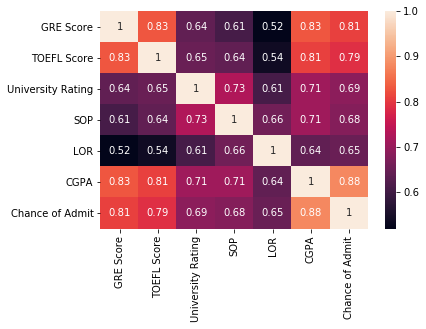

In [5]:
correlation_matrix = collegeData.iloc[:,:].corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

All predictor variables are significantly correlated to **Chance of Admit**. As a result, we will use all of them to build our model. Amongst the predictor variables themselves, three variables show a strong correlation - **TOEFL Score**, **GRE Score**, and **GPA**. All three metrics are based on academic performance, so it makes sense for them to be correlated. 

Note that the **Research** variable was automatically excluded in the chart above because we converted it to a categorical variable. It is impossible to calculate the correlation for categorical variables. Hence we will look at a different plot to get a feel for how research is distributed.

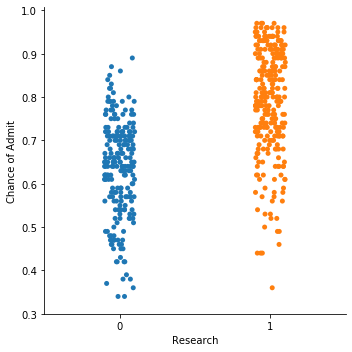

In [6]:
sns.catplot(data = collegeData, x = "Research", y = "Chance of Admit")

The **Chance of Admit** variable is centered at around 0.75 for those who have research experience, and is centered at around 0.6 for those who do not. Does this mean that having research experience drops the chance of admission by 0.15? In short, **No**. We need to keep in mind that our model will account for the variation caused by each one of the predictor variables. We will look at how important each variable is after we fit our model.  

In [7]:
X = collegeData.iloc[:,0:7]
y = collegeData.iloc[:,7]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1005)

### Model Breakdown

After experimenting with variation combinations of parameters, the following had the lowest test mean squared error **(MSE)** and the highest coefficient of detremination $(R^2)$ value.

A quick breakdown of key parameters:  
**n_estimators** : The number of decision trees that our forest contains - 250  
**max_features** : This affects the maximum number of features that will be considered at each split. Limiting the number of features to 2 seemed to work best.  
**min_samples_split** : The minimum number of samples required to split a node. Default is 2, but we set it to 5 in order to generalize better.  


In [9]:
rf = RandomForestRegressor(n_estimators=250,
                           max_features=(2/7), 
                           min_samples_split=5, 
                           n_jobs=2, 
                           random_state=1005)

In [10]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.2857142857142857,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=2,
                      oob_score=False, random_state=1005, verbose=0,
                      warm_start=False)

### Model Evaluation Metrics

We will take a look at the **MSE** and the $R^2$ value for both the training and test sets. 

In [11]:
train_predictions = rf.predict(X_train)
test_predictions = rf.predict(X_test)

train_mse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_mse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_r2 = rf.score(X_train, y_train)
test_r2 = rf.score(X_test, y_test)

print("Train MSE ::", train_mse)
print("Test MSE ::", test_mse)
print("Train R^2 ::", train_r2)
print("Test R^2 ::", test_r2)

Train MSE :: 0.035577157557505214
Test MSE :: 0.056076132715351695
Train R^2 :: 0.9354862330956815
Test R^2 :: 0.8486805018919079


The Test $R^2$ is 0.849, which means that in general, our model accounts for 84.9% of the variation in **Chance of Admit**.

### Feature Importance

Next, we take a look at which attributes affect **Chance of Admit** the most. Essentially, we are trying to find out what factors affect a student's chance of admission.

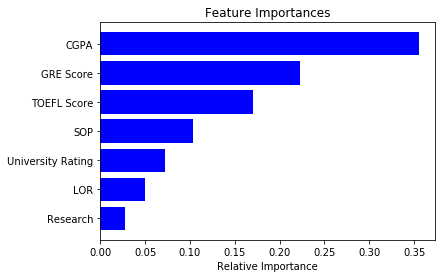

In [12]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

From the above plot, it is clear that **CGPA** and **GRE Score** play the biggest roles in affecting the admission decision. **Research** does not play a very significant role in determining the admission decision. To answer our previous question, lacking research expereince should not adversely affect the admission decision . 

### Predicting on a Custom Example

Let us define the metrics of a new person and take a look at the prediction.

Need to define the following:  
**GRE Score** - Out of 340  
**TOEFL Score** - Out of 120  
**University Rating** - Between 1 to 5 (5 being the best)  
**SOP** - Between 1 to 5 (5 being the best)  
**LOR** - Between 1 to 5 (5 being the best)  
**CGPA** - Out of 10  
**Research** - 1 if student has research experience, else 0

In [13]:
newPerson = [[330, 110, 4, 4.5, 4.5, 9.5, 0]]

In [14]:
pred = rf.predict(newPerson)
pred[0]

0.8820989365079359

For the following student:  

**GRE Score** - 330  
**TOEFL Score** - 110  
**University Rating** - 4  
**SOP** - 4.5  
**LOR** - 4.5  
**CGPA** - 9.5  
**Research** - 0 (No experience)

The chance of getting accepted into the program is **88.2%**